In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy.random as r
from tqdm import tqdm

# Her i starten indlæses bare data og korrigeres for k_acc, som vi har gjort tidligere. Led efter næste markdown, hvor der står, at der er ændringer

In [2]:
rådata_holocæn = pd.read_excel('Temperaturdata_alene.xlsx', header = 29)
rådata_holocæn = rådata_holocæn.to_numpy()
år20_rå = rådata_holocæn[:,0]
temp20_rå = rådata_holocæn[:,1]

In [3]:
rådata = pd.read_excel('Ægte_DailyMinMax_Ilullisat_Cor-2.xlsx')
data = rådata.to_numpy()
år_rå, temp_rå = data[:,0], data[:,1]

Interpolering af DMI-data

In [6]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []
    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)
    
    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])
    #print(interpol_år)
    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    print(len(år))
    return år
    
år_DMI_inter = interpolation_år()      # Interpolerer temperaturdataen

år_DMI_inter = np.array(år_DMI_inter)

temp_DMI_inter = np.interp(år_DMI_inter, år_rå, temp_rå)

216227


In [5]:
råsatellit = pd.read_csv('greenland_mass_200204_202311.txt', delimiter = '\s+', header = None, skiprows = lambda x: x < 31)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

In [7]:
top = max(år_sat)   
bund = min(år_sat)

# Slicing af DMI-data

temp_DMI = temp_DMI_inter[(år_DMI_inter <= top) & (år_DMI_inter >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
år_DMI = år_DMI_inter[(år_DMI_inter <= top) & (år_DMI_inter >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

# Slicing af GRACE-data
topDMI = max(år_DMI)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

In [8]:
råNGRIP = pd.read_excel('rådata NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]
NGRIPår0, GRIPår0 = NGRIP[:, 1], GRIP[:, 1]
NGRIP_delevation, GRIP_delevation = NGRIP[:, 8], GRIP[:, 7]

In [9]:
akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2   # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


# Bestemmelse af formkonstant

In [13]:
V = 2.99 * 10**15   # startvolumen af iskappe
H = 3 * 10**3       # Starthøjde af iskappe
R = (3/16*V/H)**(1/2)    # Startradius af iskappe
k_0 = H/np.sqrt(R)


acc_NGRIP = 0.073    # m/år
acc_GRIP = 0.107     # m/år
acc_i = (acc_GRIP + acc_NGRIP)/2
k_i = (acc_i/akk_gns)**(1/8) * k_0

print('formfaktor under sidste istid = ', k_i, 'm/år')
print('formfaktor i dag = ', k_0, 'm/år')

formfaktor under sidste istid =  4.120608174150196 m/år
formfaktor i dag =  4.562821227134003 m/år


# Funktion der bestemmer k_acc fra værdi af M_akk

In [14]:
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit

def optimering_akk(M_akk_tabel):

    V_start = 2.99 * 10**15   # startvolumen af iskappe
    H = 3 * 10**3       # Starthøjde af iskappe
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    V_sat = dvol_sat + V_0 - dvol_sat[0]
    
    R = (3/16*V/H)**(1/2)    # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k_0 = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år

    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden
    k_acc_test = 1   # Denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
    k_melt = 1

    #Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []



    for i in range(len(år_DMI)):
        R = (3/16 * V/k_0)**(2/5)     # Ny radius af iskappe
       
        V_acc = k_acc_test * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
       
        if temp_DMI[i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[i] - T_f) * ((T_f - temp_DMI[i])/(alfa * k_0))**2 * dt  # ganger tidsskridt og M på
        V += V_acc - V_melt

        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)

   
    V_sum = np.sum(V_acc_list)/(år_DMI[-1] - år_DMI[0])
    V_akk_tabel = (M_akk_tabel)/(densitet_is) #m^3

    k_acc = V_akk_tabel/V_sum
    
    return k_acc

# Normalfordelte M_akk-værdier

In [15]:
M_akk_mean = 642 * 10**12    #kg
M_akk_std = 59 * 10**12    #kg

M_akk_list = r.normal(M_akk_mean, M_akk_std, 100)

k_acc_værdier = []

for x in M_akk_list:
    k_acc = optimering_akk(x)

    k_acc_værdier.append(k_acc)

# Simuleringsfunktion til bestemmelse af k_melt

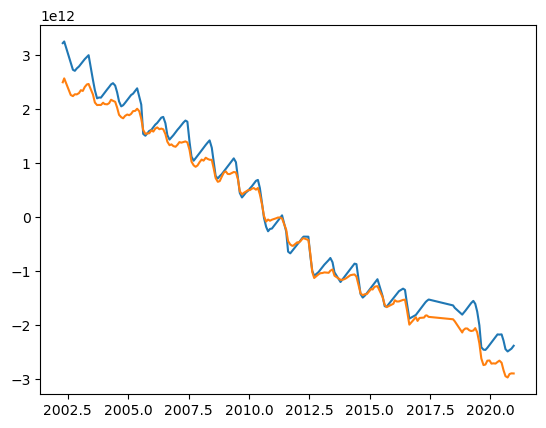

In [22]:
V_start = 2.99 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit
dvol_sat_err_korr = np.sqrt(V_sat_err**2 + (np.std(dvol_sat)/np.sqrt(len(dvol_sat)))**2)


def simulering(år_sat, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    H = 3 * 10**3       # Starthøjde af iskappe
    R = (3/16*V/H)**(1/2)     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k_0 = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år_DMI) + 1):
        R = (3/16 * V/k_0)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp_DMI[-i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[-i] - T_f) * ((T_f - temp_DMI[-i])/(alfa * k_0))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()

    dvol_sim = V_list - np.mean(V_list)

    dvol_sim_fit = np.interp(år_sat, år_DMI, dvol_sim)

    return dvol_sim_fit 


# Nedenstående er bare et tjek af den nye funktion, som er lidt anderledes end de gamle
test = simulering(år_sat, 7.341091843986271)
#
#plt.plot(år, V_list)
plt.plot(år_sat, test, label = 'simulering')
plt.plot(år_sat, dvol_sat_korr)
#plt.legend()


## Curve_fit (optimale k_melt for hver k_acc)

In [20]:
k_melt_list = []
k_melt_err_list = []

for x in tqdm(k_acc_værdier):
    k_acc = x
    par, cov = curve_fit(simulering, år_sat, dvol_sat_korr, p0 = 7, sigma = dvol_sat_err_korr, absolute_sigma= True)
    k_melt_list.append(par[0])
    k_melt_err_list.append(np.sqrt(cov[0,0]))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


# Jeg gemmer alle de relevante værdier indtil nu

In [23]:
np.savez_compressed('kørsel_M_værdier.npz', M_akk_list = M_akk_list)
np.savez_compressed('kørsel_k_acc_værdier.npz', k_acc_værdier = k_acc_værdier)
np.savez_compressed('kørsel_k_melt_værdier.npz', k_melt_list = k_melt_list)
np.savez_compressed('kørsel_k_melt_err.npz', k_melt_err_list = k_melt_err_list)

In [21]:
print(len(k_melt_list))
print(k_melt_list)
print(k_melt_err_list)

100
[7.341091843986271, 8.210891291928766, 7.8454664676094, 8.1207284654055, 8.531029609097759, 7.977496921446391, 8.149286882099773, 8.627576023288496, 8.247881588008863, 8.806177692820476, 7.635231615632534, 7.966989665346688, 8.166256755465346, 8.032850182524692, 9.540079679555525, 9.019195816862585, 8.41194483415579, 8.272834718278101, 9.133050405659718, 8.670008496476393, 8.279357772173054, 8.149527147360034, 7.228847604669843, 8.274853682827795, 8.463735239827152, 7.715673037268143, 7.9275734228676, 8.150835871413502, 9.10986006514863, 9.008350250643003, 7.930500502147672, 7.7752442896798355, 7.829751578740594, 7.358887891013749, 8.749385135760122, 9.011713116315677, 7.737236641097216, 7.911945020344993, 8.266337065487495, 8.073434397330741, 8.377681077060554, 8.225918516173705, 7.708104806343668, 6.913455076453947, 8.1902865589652, 8.492953315086552, 8.272464132872265, 8.165162567198903, 9.006292661029885, 8.14821261747629, 8.160355393259891, 8.383163383936838, 8.244323416051602

# __Lange kørsler__ - til at starte med tilpasses data ligesom vi plejer

In [25]:
gns1 = np.average(temp20_rå[0:5])

top = 1980
bund = 1880
temp_X = temp_rå[(år_rå >= bund)&(år_rå < top)]

gns2 = np.average(temp_X)

forskel = np.absolute(gns1 - gns2)

print("Forskellen er", forskel)

Forskellen er 5.5608806093626635


## Simulering af iskappevolumensudvikling gennem den sidste varmeperiode

### Udvælger 20 år (år 1955-1975) og bruger deres årstidscyklus på iskernedata

[0.000000e+00 7.000000e-04 1.400000e-03 ... 1.999795e+01 1.999860e+01
 1.999930e+01]
0.0
[0.000000e+00 7.000000e-04 1.400000e-03 ... 1.999795e+01 1.999860e+01
 1.999930e+01]


Text(0, 0.5, 'Temperaturafvigelse [$^\\circ$C]')

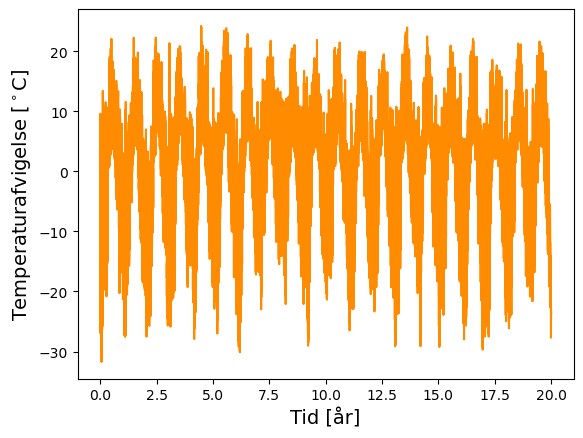

In [26]:
top = 1975
bund = 1955
maske = (år_DMI_inter >= bund) & (år_DMI_inter < top)

år_X = år_DMI_inter[maske]
år_X = år_X - år_X[0]
print(år_X)
print(min(år_X))
temp_X = temp_DMI_inter[maske]
temp_X_afv = temp_X-np.average(temp_X)

print(år_X)
plt.plot(år_X,temp_X_afv, c = 'darkorange')
plt.xlabel('Tid [år]', fontsize = 14)
plt.ylabel(r'Temperaturafvigelse [$^\circ$C]', fontsize = 14)

## Lægger årstidscyklus ind over iskernedata

In [27]:
temp_array = np.array([])
år_array = np.array([])

for i, j in np.nditer([temp20_rå, år20_rå]):
    temp_c = i + temp_X - forskel #kysttemperatur
    år_c = 2000 - j + 20 + år_X

    temp_array = np.append(temp_array, temp_c)
    år_array = np.append(år_array, år_c)

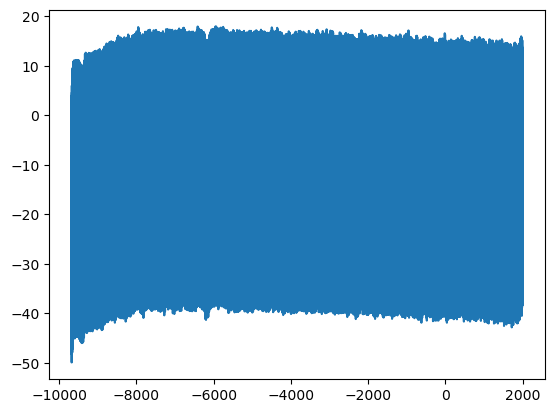

In [28]:
plt.plot(år_array, temp_array)

(0.0, 25.0)

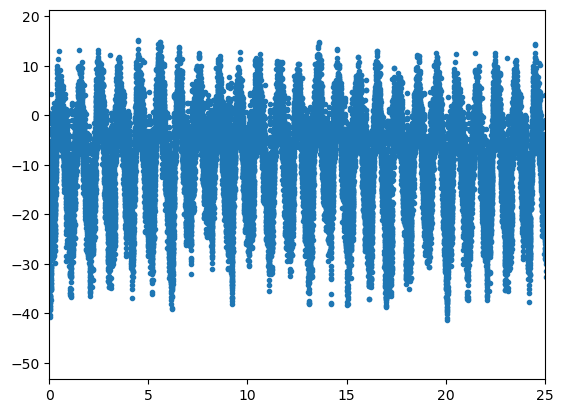

In [29]:
plt.plot(år_array, temp_array, '.')
plt.xlim(0,25)

In [30]:
GRIP_age = GRIPår0[9:-24]
NGRIP_age = NGRIPår0[16:-24]
GRIP_acc_rate = GRIPakk0[9:-24]
NGRIP_acc_rate = NGRIPakk0[16:-24]

gns_acc_rate1 = (GRIP_acc_rate + NGRIP_acc_rate)/2 #m is/år fra år 1980
gns_acc_rate = np.repeat(gns_acc_rate1, 365.25*4)*1/(365.25*4)

In [32]:
V = 2.99 * 10**15   # startvolumen af iskappe
H = 3 * 10**3       # Starthøjde af iskappe
R = (3/16*V/H)**(1/2)    # Startradius af iskappe
k_0 = H/np.sqrt(R)


acc_NGRIP = 0.073    # m/år
acc_GRIP = 0.107     # m/år
acc_i = (acc_GRIP + acc_NGRIP)/2
k_i = (acc_i/akk_gns)**(1/8) * k_0

print('formfaktor under sidste istid = ', k_i, 'm/år')
print('formfaktor i dag = ', k_0, 'm/år')

formfaktor under sidste istid =  4.120608174150196 m/år
formfaktor i dag =  4.562821227134003 m/år


# Der laves en liste med de lineært ændrede formkonstanter til den lange kørsel

In [34]:
N = 17000000
k_list_langtidskørsel = np.linspace(k_0, k_i, N)
print(k_list_langtidskørsel)
#np.savez_compressed('kørsel_formkonstantliste.npz', k_list_langtidskørsel = k_list_langtidskørsel)

[4.56282123 4.5628212  4.56282118 ... 4.12060823 4.1206082  4.12060817]


# Lang simulering. Her har jeg ændret den, så den bruger pythons egen 'enumerate' i stedet for numpys måde at iterere over to arrays. Jeg har også ændret, så der kun gemmes hvert 500. punkt

In [41]:
def langtidskørsel(k_acc, k_melt):    
    V = 2.99 * 10**15        #m^3
    H = 3 * 10**3            #m
    R = (3/16*V/H)**(1/2)          #m
    T_f = 0                  #grader
    alfa = - 9.8 * 10**(-3)  #temperaturændring pr. højdeforøgelse (deg C/m)
    k_0 = H/np.sqrt(R)         #formfaktor. Vi antager, at iskappens form ikke ændrer sig
    dt = 1/(4*365.25)        #tidsskridt i år

    #k_melt = 8.5 * 5 * 2 * 10**(-1)  #Smeltekonstant    

    V_list = []
    V_melt_list = []         #For overbliks skyld
    acc_list = []
    R_list = []
    år_list = []

    N = 17000000
    tæller = 0

    for index, (i, j) in enumerate(zip(temp_array[0:N], gns_acc_rate[0:N])):
             
        R = (3/16 * V/k_list_langtidskørsel[index])**(2/5)  #Jeppes formel. Undersøges senere
        V_acc = k_acc * (j * 8 * R**2)*dt  #Volumen tilført pr tidsskridt.

        if i - T_f < 0:
            V_melt = 0

        elif i == 0:
            V_melt = 0

        elif i - T_f > 0:
            V_melt = dt*k_melt * 8/3 * R * (i - T_f) * ((T_f - i)/(alfa * k_list_langtidskørsel[index]))**2 #Vi undersøger dette integrale senere #Tiføj ekstra getjerkonstant fra isbjergedannelse. + k_isbjerg
            #og r_f = R - ((T_f - temp[t])/(alfa * k))**2

        V +=  - V_acc + V_melt  #Omvendt fortegn for at gå tilbage i tid

        if tæller % 500 == 0:
            V_list.append(V)
            V_melt_list.append(V_melt)
            acc_list.append(V_acc)
            R_list.append(R)
            år_list.append(år_array[tæller])
            tæller += 1
        else:
            tæller += 1

    V_list = np.array(V_list)
    R_list = np.array(R_list)
    år_list = np.array(år_list)

    return V_list, R_list, år_list, V_melt_list, acc_list

# Jeg gemmer tidsarrayet for alle kørslerne

In [42]:
V_list, R_list, år_list, V_melt_list, acc_list = langtidskørsel(k_acc_værdier[0], k_melt_list[0])
np.savez_compressed(f'kørsel_årstal.npz', år_list = år_list)

# Herunder udføres de 100 kørsler og de relevante arrays gemmes

In [44]:
for i in tqdm(range(len(k_acc_værdier))):
    V_list, R_list, år_list, V_melt_list, acc_list = langtidskørsel(k_acc_værdier[i], k_melt_list[i])
    np.savez_compressed(f'kørsel_voluminer{i}.npz', V_list = V_list)
    np.savez_compressed(f'kørsel_radier{i}.npz', R_list = R_list)
    np.savez_compressed(f'kørsel_V_melt{i}.npz', V_melt_list = V_melt_list)
    np.savez_compressed(f'kørsel_V_acc{i}.npz', acc_list = acc_list)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [56:00<00:00, 33.61s/it]


# Jeg gemmer en slicet udgave af formkonstantarrayet, som (ligesom resten af simuleringen) kun har en værdi for hvert 500. punkt

In [47]:
k_list_langtidskørsel_plot = []

for i in range(len(k_list_langtidskørsel)):
    if i % 500 == 0:
        k_list_langtidskørsel_plot.append(k_list_langtidskørsel[i])

k_list_langtidskørsel_plot = np.array(k_list_langtidskørsel_plot)
len(k_list_langtidskørsel_plot)
len(R_list)

34000

In [48]:
np.savez_compressed('kørsel_formkonstantlistee.npz', k_list_langtidskørsel_plot = k_list_langtidskørsel_plot)